In [1]:
import pandas as pd

# Load Reddit dataset
df_reddit = pd.read_csv("/kaggle/input/reddit/reddit.csv")
print("Reddit dataset info:")
print(df_reddit.info())
print(df_reddit.head())



Reddit dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB
None
       subreddit                                               body  \
0  gameofthrones  Your submission has been automatically removed...   
1            aww  Dont squeeze her with you massive hand, you me...   
2         gaming  It's pretty well known and it was a paid produ...   
3           news  You know we have laws against that currently c...   
4       politics  Yes, there is a difference between gentle supp...   

   controversiality  score  
0                 0      1  
1                 0     19  
2         

In [2]:
df_insta = pd.read_csv("/kaggle/input/instagram/combined_captions_cleaned.csv")
print("Instagram dataset info:")
print(df_insta.info())
print(df_insta.head())


Instagram dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17100 entries, 0 to 17099
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Sr No                              17100 non-null  float64
 1   Image File                         17100 non-null  object 
 2   Caption                            17100 non-null  object 
 3   20516                              0 non-null      float64
 4   img2/insta20516                    0 non-null      float64
 5   wHaT dAy Is It Even #stayhomeclub  0 non-null      float64
dtypes: float64(4), object(2)
memory usage: 801.7+ KB
None
   Sr No  Image File                                            Caption  \
0    2.0  img/insta2                                               bye    
1    3.0  img/insta3  Ok, a few more... sorry I just had so much fun...   
2    4.0  img/insta4  This was one of my favorite shoots I’ve ever d... 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
def clean_text_vectorized(df, text_column):
    df_clean = df.copy()
    df_clean[text_column] = df_clean[text_column].astype(str).str.lower()
    df_clean[text_column] = df_clean[text_column].str.replace(r"http\S+|www\S+", "", regex=True)
    df_clean[text_column] = df_clean[text_column].str.replace(r"[^a-zA-Z0-9\s#]", "", regex=True)
    df_clean[text_column] = df_clean[text_column].str.replace(r"\s+", " ", regex=True).str.strip()
    return df_clean


In [4]:
text_col_reddit = 'body' if 'body' in df_reddit.columns else 'text'
df_reddit = df_reddit[[text_col_reddit]]
df_reddit['source'] = 'reddit'
df_reddit.rename(columns={text_col_reddit:'text'}, inplace=True)

df_reddit = clean_text_vectorized(df_reddit, 'text')
df_reddit.rename(columns={'text':'clean_text'}, inplace=True)
print(df_reddit.head())


                                          clean_text  source
0  your submission has been automatically removed...  reddit
1  dont squeeze her with you massive hand you mea...  reddit
2  its pretty well known and it was a paid produc...  reddit
3  you know we have laws against that currently c...  reddit
4  yes there is a difference between gentle suppr...  reddit


In [5]:
text_col_insta = 'Caption' if 'Caption' in df_insta.columns else 'text'
df_insta = df_insta[[text_col_insta]]
df_insta['source'] = 'instagram'
df_insta.rename(columns={text_col_insta:'text'}, inplace=True)

df_insta = clean_text_vectorized(df_insta, 'text')
df_insta.rename(columns={'text':'clean_text'}, inplace=True)
print(df_insta.head())


                                          clean_text     source
0                                                bye  instagram
1  ok a few more sorry i just had so much fun tha...  instagram
2  this was one of my favorite shoots ive ever do...  instagram
3                wrapped round my finger like a ring  instagram
4  yesterday was so much fun has been such a huge...  instagram


In [6]:
df_combined = pd.concat([df_reddit, df_insta], ignore_index=True)
print("Combined dataset shape:", df_combined.shape)
df_combined.to_csv('/kaggle/working/combined_cleaned_social_media.csv', index=False)


Combined dataset shape: (1017100, 2)


In [7]:
# Sample 2000 rows for fast hierarchical clustering
df_sample = df_combined.sample(2000, random_state=42).reset_index(drop=True)
print("Sampled dataset shape (for hierarchical clustering):", df_sample.shape)


Sampled dataset shape (for hierarchical clustering): (2000, 2)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df_sample['clean_text'])
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (2000, 1000)


In [9]:
from scipy.cluster.hierarchy import linkage, fcluster

# Compute linkage matrix (Ward method)
linkage_matrix = linkage(X.toarray(), method='ward')

# Define number of clusters
num_clusters = 5

# Assign clusters
df_sample['cluster'] = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Check cluster distribution
print(df_sample['cluster'].value_counts())


cluster
5    1938
3      25
4      18
1      12
2       7
Name: count, dtype: int64


In [10]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
num_sample_texts = 5
num_top_words = 10

for i in range(1, num_clusters+1):
    print(f"\n=== Cluster {i} ===")
    cluster_df = df_sample[df_sample['cluster'] == i]
    
    # Sample texts
    sample_texts = cluster_df['clean_text'].sample(n=min(num_sample_texts, len(cluster_df)), random_state=42).tolist()
    for text in sample_texts:
        print("-", text)
    
    # Sum vectors of cluster documents
    cluster_indices = cluster_df.index  # safe because df_sample has reset_index
    cluster_vector_sum = X[cluster_indices].sum(axis=0).A1
    top_idx = np.argsort(cluster_vector_sum)[::-1][:num_top_words]
    top_words = [feature_names[idx] for idx in top_idx]
    print("Top words:", top_words)
    
    # Source distribution
    source_counts = cluster_df['source'].value_counts()
    print("Source distribution:", source_counts.to_dict())



=== Cluster 1 ===
- give them raw or cooked chicken or like do you prepare it into a pate or something
- or something like the newu stations from borderlands 2 with a robot voice
- well this aged like a glass of milk in the summer
- gross seems like something a cop would do though
- degenerates like you belong on a cross
Top words: ['like', 'great', 'government', 'gotten', 'gotta', 'got', 'google', 'good', 'gonna', 'gold']
Source distribution: {'reddit': 11, 'instagram': 1}

=== Cluster 2 ===
- if this is a dank meme upvote this comment if this is not a dank meme downvote this comment if this post breaks the rules report it and downvote this comment thank you for helping us in keeping rdankmemes dank hit us up if you have any questions im a bot
- if this is a dank meme upvote this comment if this is not a dank meme downvote this comment if this post breaks the rules report it and downvote this comment thank you for helping us in keeping rdankmemes dank hit us up if you have any questi

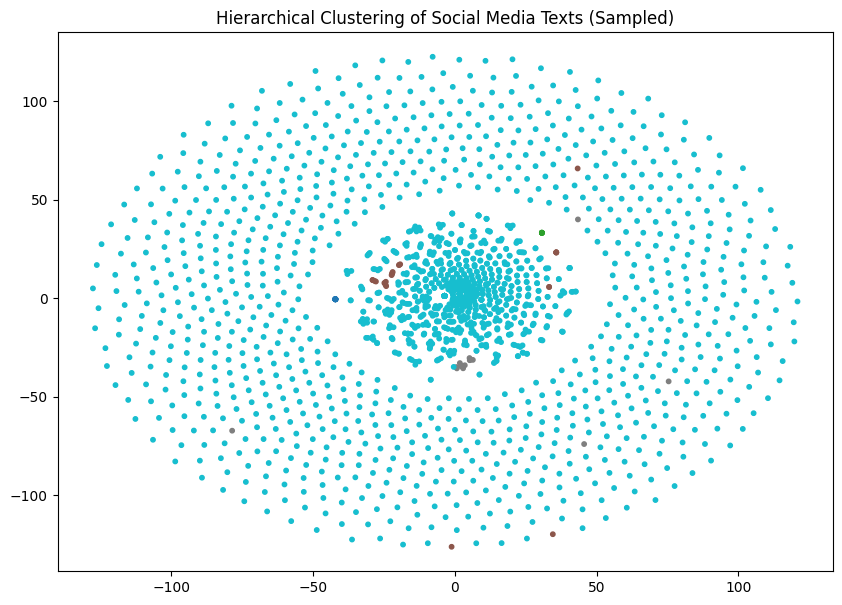

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10,7))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_sample['cluster'], cmap='tab10', s=10)
plt.title("Hierarchical Clustering of Social Media Texts (Sampled)")
plt.show()


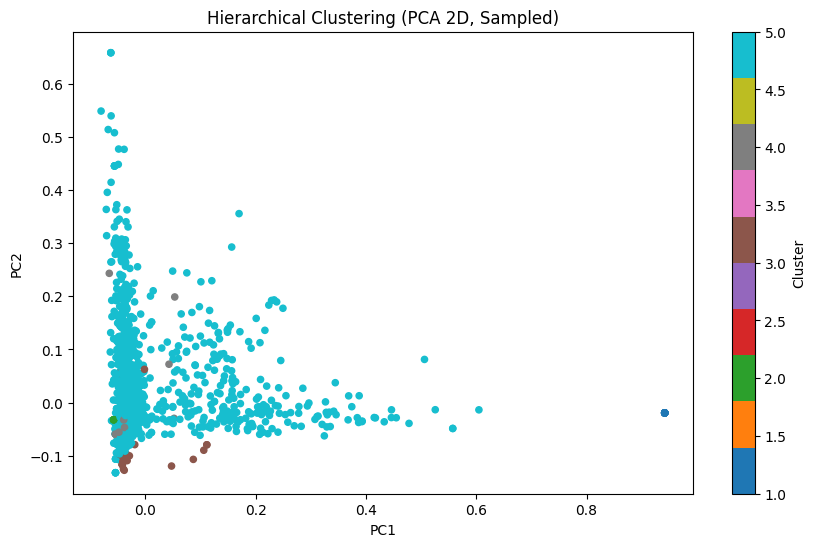

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray())

plt.figure(figsize=(10,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=df_sample['cluster'], cmap='tab10', s=20)
plt.title("Hierarchical Clustering (PCA 2D, Sampled)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()


In [13]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, df_sample['cluster'])
print("Silhouette Score (Sampled):", score)


Silhouette Score (Sampled): 0.0249379835674725


In [14]:
import joblib
import os

os.makedirs("/kaggle/working/models", exist_ok=True)

joblib.dump(vectorizer, '/kaggle/working/models/tfidf_hierarchical.pkl')
joblib.dump(linkage_matrix, '/kaggle/working/models/linkage_matrix.pkl')


['/kaggle/working/models/linkage_matrix.pkl']

In [15]:
df_sample.to_csv('/kaggle/working/clustered_data_hierarchical_sampled.csv', index=False)


In [16]:
def clean_text_data(df, text_column='clean_text'):
    df_clean = df.copy()
    df_clean[text_column] = df_clean[text_column].astype(str).replace('nan','')
    df_clean = df_clean[df_clean[text_column].str.strip() != '']
    df_clean = df_clean[df_clean[text_column].str.len() >= 10]
    return df_clean

df_sample_clean = clean_text_data(df_sample)


In [17]:
def summarize_clusters(df_split, X_split, num_clusters=5):
    feature_names = vectorizer.get_feature_names_out()
    for i in range(1, num_clusters+1):
        cluster_df = df_split[df_split['cluster']==i]
        if cluster_df.empty:
            continue
        sample_texts = cluster_df['clean_text'].sample(min(5,len(cluster_df)), random_state=42)
        print(f"\nCluster {i} samples:")
        for t in sample_texts:
            print("-", t)
        cluster_vec_sum = X_split[cluster_df.index].sum(axis=0).A1
        top_idx = np.argsort(cluster_vec_sum)[::-1][:10]
        top_words = [feature_names[j] for j in top_idx]
        print("Top words:", top_words)


In [18]:
summarize_clusters(df_sample_clean, X)



Cluster 1 samples:
- give them raw or cooked chicken or like do you prepare it into a pate or something
- or something like the newu stations from borderlands 2 with a robot voice
- well this aged like a glass of milk in the summer
- gross seems like something a cop would do though
- degenerates like you belong on a cross
Top words: ['like', 'great', 'government', 'gotten', 'gotta', 'got', 'google', 'good', 'gonna', 'gold']

Cluster 2 samples:
- if this is a dank meme upvote this comment if this is not a dank meme downvote this comment if this post breaks the rules report it and downvote this comment thank you for helping us in keeping rdankmemes dank hit us up if you have any questions im a bot
- if this is a dank meme upvote this comment if this is not a dank meme downvote this comment if this post breaks the rules report it and downvote this comment thank you for helping us in keeping rdankmemes dank hit us up if you have any questions im a bot
- if this is a dank meme upvote this 

In [19]:
import shutil

shutil.move('/kaggle/working/models/tfidf_hierarchical.pkl', '/kaggle/working/models/tfidf_hierarchical.pkl')
shutil.move('/kaggle/working/models/linkage_matrix.pkl', '/kaggle/working/models/linkage_matrix.pkl')


'/kaggle/working/models/linkage_matrix.pkl'

In [20]:
df_check = pd.read_csv('/kaggle/working/clustered_data_hierarchical_sampled.csv')
print(df_check.head())
print(df_check['cluster'].value_counts())


                                          clean_text  source  cluster
0  your dog looks very similar to my dog how old ...  reddit        5
1                   your chemistry puns are so basic  reddit        5
2  because the fact that we waste our time with t...  reddit        5
3               its not illegal to call someone that  reddit        5
4  we have a high iq person here folks tread ligh...  reddit        5
cluster
5    1938
3      25
4      18
1      12
2       7
Name: count, dtype: int64


In [21]:
df_new_clean = clean_text_data(df_check)
print("Cleaned new dataset shape:", df_new_clean.shape)


Cleaned new dataset shape: (1948, 3)


In [22]:
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, fcluster

def robust_hierarchical_pipeline(df, text_column='clean_text', num_clusters=5, sample_size=2000):
    # Sample for speed
    df_sample = df.sample(min(sample_size, len(df)), random_state=42).reset_index(drop=True)
    
    # Clean text
    df_sample[text_column] = df_sample[text_column].fillna('').astype(str)
    df_sample = df_sample[df_sample[text_column].str.strip() != '']
    
    # Vectorize
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
    X = vectorizer.fit_transform(df_sample[text_column])
    
    # Hierarchical clustering
    linkage_matrix = linkage(X.toarray(), method='ward')
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    df_sample['cluster'] = cluster_labels
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    
    return df_sample, X, vectorizer, linkage_matrix

# Run pipeline
df_clustered, X_matrix, tfidf_vect, linkage_mat = robust_hierarchical_pipeline(df_combined)


Silhouette Score: 0.008


In [23]:
!pip install seaborn


📊 Preparing Hierarchical Clustering pipeline...
1. Vectorizing text with TF-IDF...
   TF-IDF matrix shape: (1960, 5000)
2. Performing Hierarchical clustering with 5 clusters...
   Silhouette Score: 0.008
3. Extracting top words per cluster...
   Cluster 1: love, id love, love 3000, 3000, id
   Cluster 2: like, just, dont, im, people
   Cluster 3: dank, comment, downvote comment, dank meme, downvote
   Cluster 4: need, make, submissions, make comments, make submissions
   Cluster 5: automatically, moderators, contact moderators, questions concerns, automatically contact
4. Creating PCA 2D visualization...


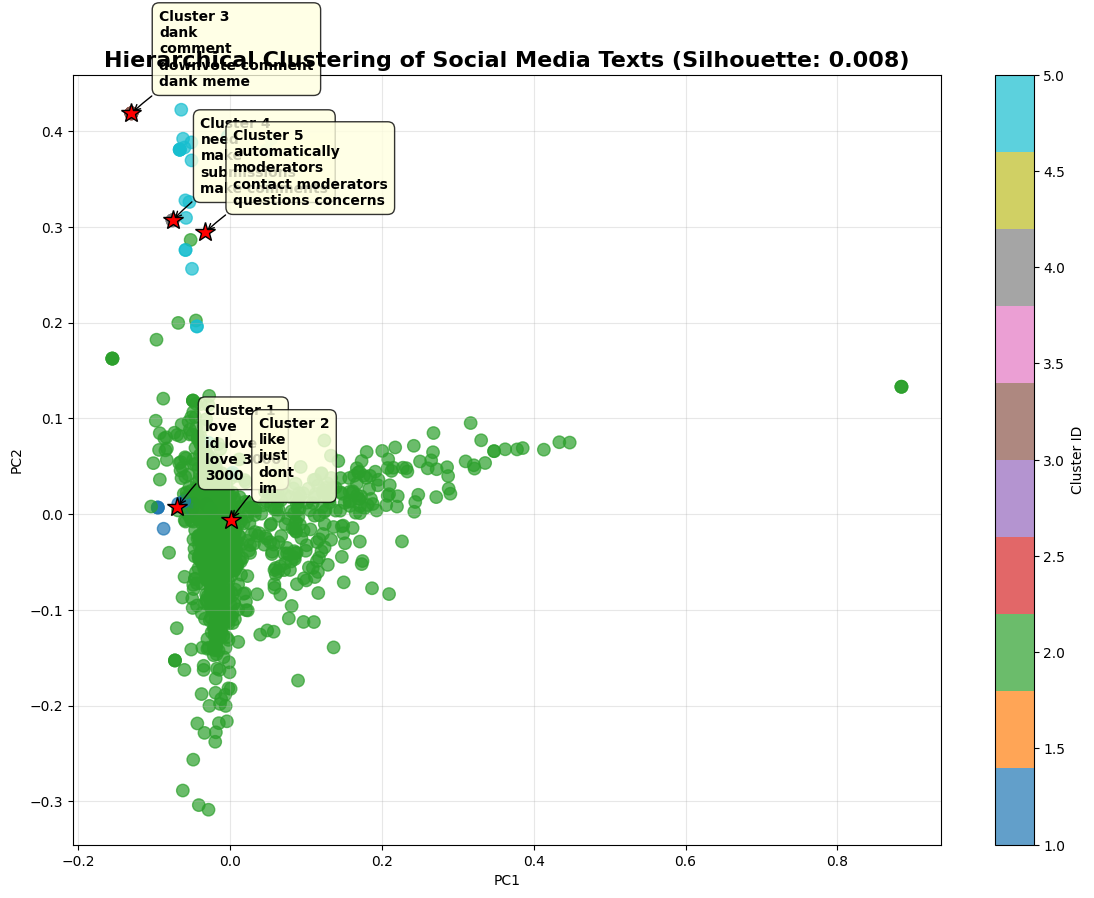

In [24]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import os

print("📊 Preparing Hierarchical Clustering pipeline...")

def working_hierarchical_pipeline(df, text_column='clean_text', num_clusters=5, sample_size=2000):
    """
    Safe Hierarchical Clustering pipeline with plotting and top words
    """
    # Sample for speed
    df_sample = df.sample(min(sample_size, len(df)), random_state=42).reset_index(drop=True)
    
    # Clean text
    df_sample[text_column] = df_sample[text_column].fillna('').astype(str)
    df_sample = df_sample[df_sample[text_column].str.strip() != '']
    
    if len(df_sample) == 0:
        raise ValueError("No valid text documents after cleaning!")
    
    # TF-IDF vectorization
    print("1. Vectorizing text with TF-IDF...")
    vectorizer = TfidfVectorizer(
        max_features=5000, 
        stop_words='english',
        ngram_range=(1,2)
    )
    X = vectorizer.fit_transform(df_sample[text_column])
    print(f"   TF-IDF matrix shape: {X.shape}")
    
    # Hierarchical clustering
    print(f"2. Performing Hierarchical clustering with {num_clusters} clusters...")
    linkage_matrix = linkage(X.toarray(), method='ward')
    labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    df_sample['cluster'] = labels
    
    # Silhouette score
    if num_clusters > 1:
        silhouette_avg = silhouette_score(X, labels)
        print(f"   Silhouette Score: {silhouette_avg:.3f}")
    else:
        silhouette_avg = 0
        print("   Silhouette Score: N/A (only one cluster)")
    
    # Top words per cluster
    print("3. Extracting top words per cluster...")
    feature_names = vectorizer.get_feature_names_out()
    top_words_per_cluster = {}
    for i in range(1, num_clusters+1):
        cluster_mask = labels == i
        if cluster_mask.sum() == 0:
            top_words_per_cluster[i] = []
            continue
        cluster_vectors = X[cluster_mask]
        word_scores = np.array(cluster_vectors.sum(axis=0)).flatten()
        top_idx = word_scores.argsort()[::-1][:10]
        top_words_per_cluster[i] = [feature_names[idx] for idx in top_idx]
        print(f"   Cluster {i}: {', '.join(top_words_per_cluster[i][:5])}")
    
    # Visualization
    print("4. Creating PCA 2D visualization...")
    X_2d = PCA(n_components=2, random_state=42).fit_transform(X.toarray())
    plt.figure(figsize=(14,10))
    scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='tab10', s=80, alpha=0.7)
    
    # Annotate clusters
    for cluster_id in np.unique(labels):
        cluster_points = X_2d[labels==cluster_id]
        center = cluster_points.mean(axis=0)
        words_text = "\n".join(top_words_per_cluster[cluster_id][:4])
        plt.annotate(f"Cluster {cluster_id}\n{words_text}", xy=center, xytext=(20,20),
                     textcoords='offset points', fontsize=10, weight='bold',
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8),
                     arrowprops=dict(arrowstyle='->', color='black', connectionstyle='arc3,rad=0.1'))
        plt.plot(center[0], center[1], 'r*', markersize=15, markeredgecolor='black')
    
    plt.title(f"Hierarchical Clustering of Social Media Texts (Silhouette: {silhouette_avg:.3f})", fontsize=16, weight='bold')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Cluster ID')
    plt.show()
    
    return df_sample, X, vectorizer, linkage_matrix, top_words_per_cluster

# Run pipeline
df_hierarchical, X_hier, tfidf_vect, linkage_mat, top_words_hier = working_hierarchical_pipeline(
    df_combined, text_column='clean_text', num_clusters=5
)


In [25]:
# Create folder for saving models/results
os.makedirs("/kaggle/working/hierarchical_results", exist_ok=True)

# Save clustered data
df_hierarchical.to_csv('/kaggle/working/hierarchical_results/clustered_hierarchical.csv', index=False)

# Save TF-IDF vectorizer and linkage matrix
import joblib
joblib.dump(tfidf_vect, '/kaggle/working/hierarchical_results/tfidf_vectorizer.pkl')
joblib.dump(linkage_mat, '/kaggle/working/hierarchical_results/linkage_matrix.pkl')

print("✅ Hierarchical clustering results saved successfully!")
print(f"   - Clustered data CSV: /kaggle/working/hierarchical_results/clustered_hierarchical.csv")
print(f"   - TF-IDF vectorizer: /kaggle/working/hierarchical_results/tfidf_vectorizer.pkl")
print(f"   - Linkage matrix: /kaggle/working/hierarchical_results/linkage_matrix.pkl")


✅ Hierarchical clustering results saved successfully!
   - Clustered data CSV: /kaggle/working/hierarchical_results/clustered_hierarchical.csv
   - TF-IDF vectorizer: /kaggle/working/hierarchical_results/tfidf_vectorizer.pkl
   - Linkage matrix: /kaggle/working/hierarchical_results/linkage_matrix.pkl


In [26]:
import os
print(os.listdir('.'))  # Lists files in the current directory


['clustered_data_hierarchical_sampled.csv', 'models', 'hierarchical_results', '.virtual_documents', 'combined_cleaned_social_media.csv']


In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import time

start_time = time.time()

# Load hierarchical clustered sample
csv_file_path = "clustered_data_hierarchical_sampled.csv"  # adjust path if needed
df = pd.read_csv(csv_file_path)
print(f"Original dataset: {df.shape}")

# Sample for speed
SAMPLE_SIZE = 5000
df_small = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)
print(f"Using sample of {len(df_small)} records for speed")

# Auto-detect text column
text_column = None
for col in df_small.columns:
    if any(k in col.lower() for k in ['text', 'content', 'body', 'clean', 'message']):
        text_column = col
        break
if text_column is None:
    text_column = df_small.columns[0]

print(f"Using column: '{text_column}'")

# Quick cleaning
df_small[text_column] = df_small[text_column].fillna('').astype(str)
df_small = df_small[df_small[text_column].str.strip() != '']
print(f"After cleaning: {len(df_small)} documents")


Original dataset: (2000, 3)
Using sample of 2000 records for speed
Using column: 'clean_text'
After cleaning: 1960 documents


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=1000,  # adjust for speed
    stop_words='english',
    min_df=5,
    max_df=0.9
)
X = vectorizer.fit_transform(df_small[text_column])
print(f"TF-IDF matrix shape: {X.shape}")


TF-IDF matrix shape: (1960, 1000)


In [29]:
# Agglomerative with cosine affinity cannot handle zero vectors
non_zero_mask = np.array(X.sum(axis=1)).flatten() != 0
X_nonzero = X[non_zero_mask]
df_small_nonzero = df_small[non_zero_mask]
print(f"After removing zero vectors: {X_nonzero.shape[0]} documents")


After removing zero vectors: 1849 documents


In [30]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 6  # adjust as needed
agg = AgglomerativeClustering(
    n_clusters=n_clusters,
    affinity='cosine',
    linkage='average'
)
labels = agg.fit_predict(X_nonzero.toarray())
df_small_nonzero['cluster'] = labels

# Cluster distribution
print("Cluster distribution:")
for i in range(n_clusters):
    count = (labels == i).sum()
    print(f"  Cluster {i}: {count} posts ({count/len(labels)*100:.1f}%)")


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Cluster distribution:
  Cluster 0: 1726 posts (93.3%)
  Cluster 1: 9 posts (0.5%)
  Cluster 2: 81 posts (4.4%)
  Cluster 3: 7 posts (0.4%)
  Cluster 4: 15 posts (0.8%)
  Cluster 5: 11 posts (0.6%)


/tmp/ipykernel_86/3249362160.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small_nonzero['cluster'] = labels


In [31]:
feature_names = vectorizer.get_feature_names_out()
top_words = {}

for i in range(n_clusters):
    cluster_mask = labels == i
    if cluster_mask.sum() > 0:
        word_scores = np.array(X_nonzero[cluster_mask].sum(axis=0)).flatten()
        top_indices = word_scores.argsort()[-5:][::-1]  # top 5 words
        top_words[i] = [feature_names[idx] for idx in top_indices]

print("\nTop words per cluster:")
for i, words in top_words.items():
    print(f"  Cluster {i}: {', '.join(words)}")



Top words per cluster:
  Cluster 0: like, just, dont, im, think
  Cluster 1: ignorant, added, title, easily, subject
  Cluster 2: lol, guy, tonight, annoying, catch
  Cluster 3: cat, ask, alive, knows, dead
  Cluster 4: lmao, calls, went, drop, probably
  Cluster 5: tho, mass, gotta, final, america


In [32]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

sil_score = silhouette_score(X_nonzero, labels)
dbi = davies_bouldin_score(X_nonzero.toarray(), labels)
chi = calinski_harabasz_score(X_nonzero.toarray(), labels)

print("\n=== Cluster Quality Metrics ===")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi:.4f}")
print(f"Calinski-Harabasz Index: {chi:.2f}")



=== Cluster Quality Metrics ===
Silhouette Score: 0.0019
Davies-Bouldin Index: 5.2744
Calinski-Harabasz Index: 2.91


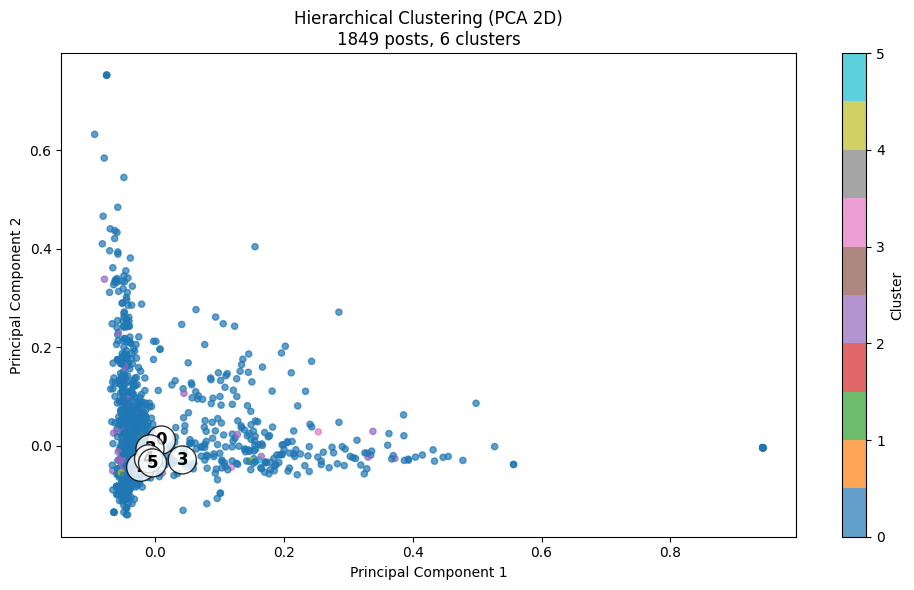

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_nonzero.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)

for i in range(n_clusters):
    cluster_points = X_2d[labels == i]
    if len(cluster_points) > 0:
        center = cluster_points.mean(axis=0)
        plt.text(center[0], center[1], f'{i}', fontsize=12, weight='bold',
                 bbox=dict(boxstyle="circle,pad=0.3", facecolor='white', alpha=0.8))

plt.title(f'Hierarchical Clustering (PCA 2D)\n{len(df_small_nonzero)} posts, {n_clusters} clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


In [34]:
df_small_nonzero.to_csv('hierarchical_clustered_sample.csv', index=False)
print("Saved clustered sample to 'hierarchical_clustered_sample.csv'")

elapsed = time.time() - start_time
print(f"\nCOMPLETED IN {elapsed:.1f} SECONDS!")


Saved clustered sample to 'hierarchical_clustered_sample.csv'

COMPLETED IN 1.9 SECONDS!


TREND DETECTION WITH HIERARCHICAL CLUSTERS

TRENDS FOUND (6 total):

1. Cluster 0
   Volume: 1726 posts (93.3%)
   Keywords: the, and, you, that, this
   Engagement Score: 2.1/10
   Sample posts:
      1. francis bean cobain called she wants her parents back
      2. there landed also a lot of material on the cutting floor
      3. unfortunately weve had to remove your post # humor guidelines memes must include fortnite assets and generic internet te...

2. Cluster 2
   Volume: 81 posts (4.4%)
   Keywords: the, and, lol, this, you
   Engagement Score: 1.3/10
   Sample posts:
      1. i think most of us are still baffled about why they were sold on him as their franchise guy and trying to make sense out...
      2. lol i need karma
      3. why would you be pro m4a and be antivaxx lol

3. Cluster 4
   Volume: 15 posts (0.8%)
   Keywords: calls, lmao, the, went, drop
   Engagement Score: 1.1/10
   Sample posts:
      1. lmao very into consideration
      2. why else would you be so eager

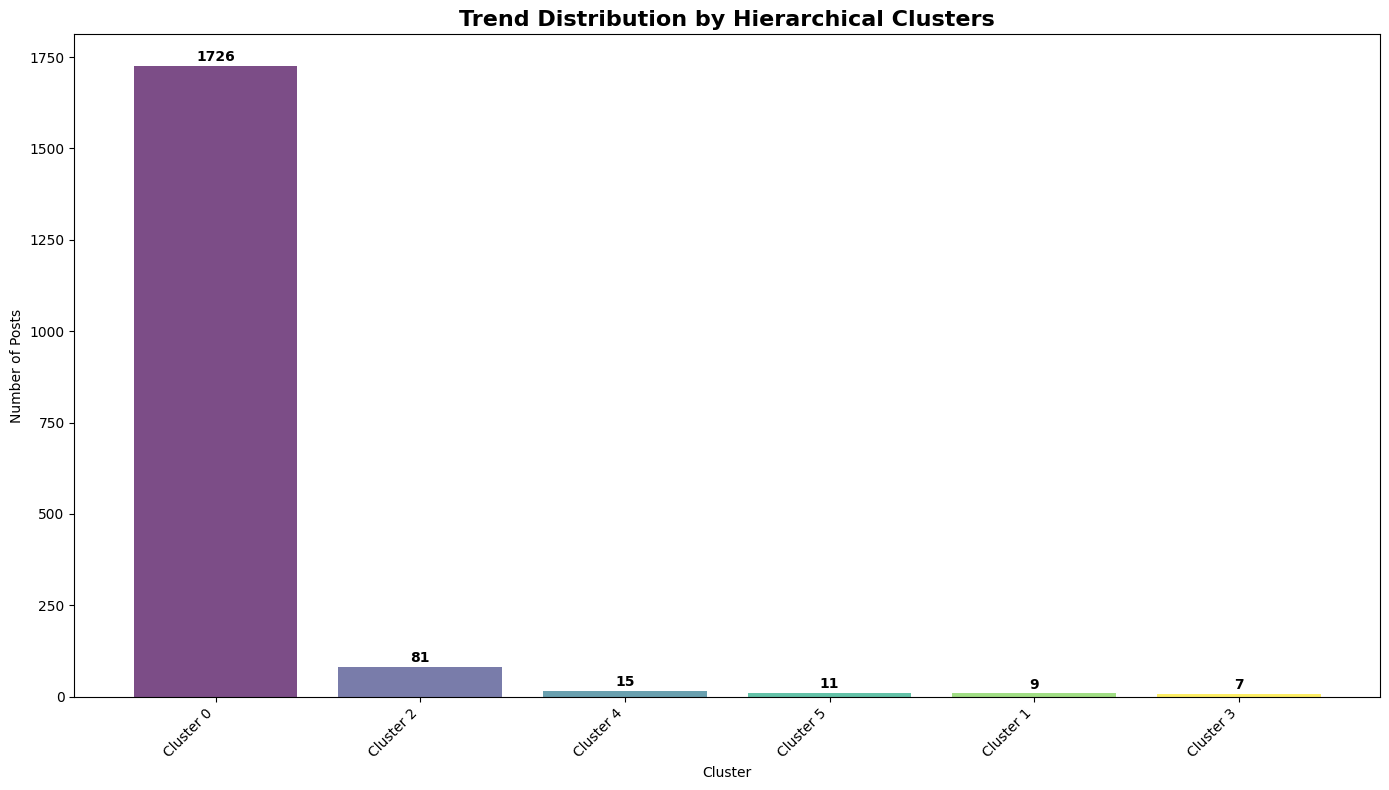

In [35]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

print("TREND DETECTION WITH HIERARCHICAL CLUSTERS")
print("=" * 60)

# Use the clustered sample
df_trend = df_small_nonzero.copy()

# Function to filter meaningful keywords
def filter_meaningful_keywords(keywords, texts):
    generic_words = {
        'like', 'just', 'know', 'think', 'people', 'really', 'would', 'could', 
        'should', 'dont', 'cant', 'wont', 'get', 'got', 'see', 'look', 'said',
        'say', 'make', 'made', 'time', 'good', 'great', 'bad', 'better', 'best',
        'right', 'wrong', 'way', 'thing', 'things', 'stuff', 'something', 'anything',
        'maybe', 'probably', 'actually', 'literally', 'basically', 'seriously'
    }
    meaningful = []
    for keyword in keywords:
        if (keyword not in generic_words and len(keyword) > 2 and not keyword.isdigit()):
            count = sum(1 for text in texts if keyword in text.lower())
            if count > len(texts) * 0.1:  # appears in ≥10% of cluster
                meaningful.append(keyword)
    return meaningful[:15]

# Function to calculate engagement score
def calculate_engagement(texts):
    if not texts:
        return 0
    avg_length = np.mean([len(text.split()) for text in texts])
    question_count = sum(1 for text in texts if '?' in text)
    exclamation_count = sum(1 for text in texts if '!' in text)
    score = min(10, (avg_length / 15) + (question_count / len(texts) * 3) + (exclamation_count / len(texts) * 2))
    return round(score, 1)

# Extract trends
trends = []
for cluster_id in sorted(df_trend['cluster'].unique()):
    cluster_texts = df_trend[df_trend['cluster'] == cluster_id][text_column].tolist()
    if len(cluster_texts) < 5:
        continue  # skip very small clusters
    
    # Tokenize and count words
    all_words = ' '.join(cluster_texts).lower()
    words = re.findall(r'\b\w+\b', all_words)
    word_counts = Counter(words)
    
    # Top 15 keywords filtered
    top_keywords = [word for word, _ in word_counts.most_common(15)]
    meaningful_keywords = filter_meaningful_keywords(top_keywords, cluster_texts)
    
    if not meaningful_keywords:
        continue
    
    trends.append({
        'trend_id': cluster_id,
        'size': len(cluster_texts),
        'percentage': len(cluster_texts) / len(df_trend) * 100,
        'keywords': meaningful_keywords[:8],
        'sample_posts': cluster_texts[:3],
        'engagement_score': calculate_engagement(cluster_texts)
    })

# Sort trends by size
trends = sorted(trends, key=lambda x: x['size'], reverse=True)

# Display trends
print(f"\nTRENDS FOUND ({len(trends)} total):")
for i, trend in enumerate(trends, 1):
    print(f"\n{i}. Cluster {trend['trend_id']}")
    print(f"   Volume: {trend['size']} posts ({trend['percentage']:.1f}%)")
    print(f"   Keywords: {', '.join(trend['keywords'][:5])}")
    print(f"   Engagement Score: {trend['engagement_score']}/10")
    print("   Sample posts:")
    for j, post in enumerate(trend['sample_posts'], 1):
        preview = post[:120] + "..." if len(post) > 120 else post
        print(f"      {j}. {preview}")

# Visualization
plt.figure(figsize=(14, 8))
trend_names = [f"Cluster {t['trend_id']}" for t in trends]
trend_sizes = [t['size'] for t in trends]

colors = plt.cm.viridis(np.linspace(0, 1, len(trends)))
bars = plt.bar(trend_names, trend_sizes, color=colors, alpha=0.7)

plt.title('Trend Distribution by Hierarchical Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, size in zip(bars, trend_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{size}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


TREND DETECTION WITH HIERARCHICAL CLUSTERS (WITH TOPIC LABELING)

TRENDS FOUND (6 total):

1. Sports & Events
   Volume: 1726 posts (93.3%)
   Keywords: the, and, you, that, this
   Engagement Score: 2.1/10
   Sample posts:
      1. francis bean cobain called she wants her parents back
      2. there landed also a lot of material on the cutting floor
      3. unfortunately weve had to remove your post # humor guidelines memes must include fortnite assets and generic internet te...

2. Personal Stories
   Volume: 81 posts (4.4%)
   Keywords: the, and, lol, this, you
   Engagement Score: 1.3/10
   Sample posts:
      1. i think most of us are still baffled about why they were sold on him as their franchise guy and trying to make sense out...
      2. lol i need karma
      3. why would you be pro m4a and be antivaxx lol

3. Discussion about calls, lmao
   Volume: 15 posts (0.8%)
   Keywords: calls, lmao, the, went, drop
   Engagement Score: 1.1/10
   Sample posts:
      1. lmao very into

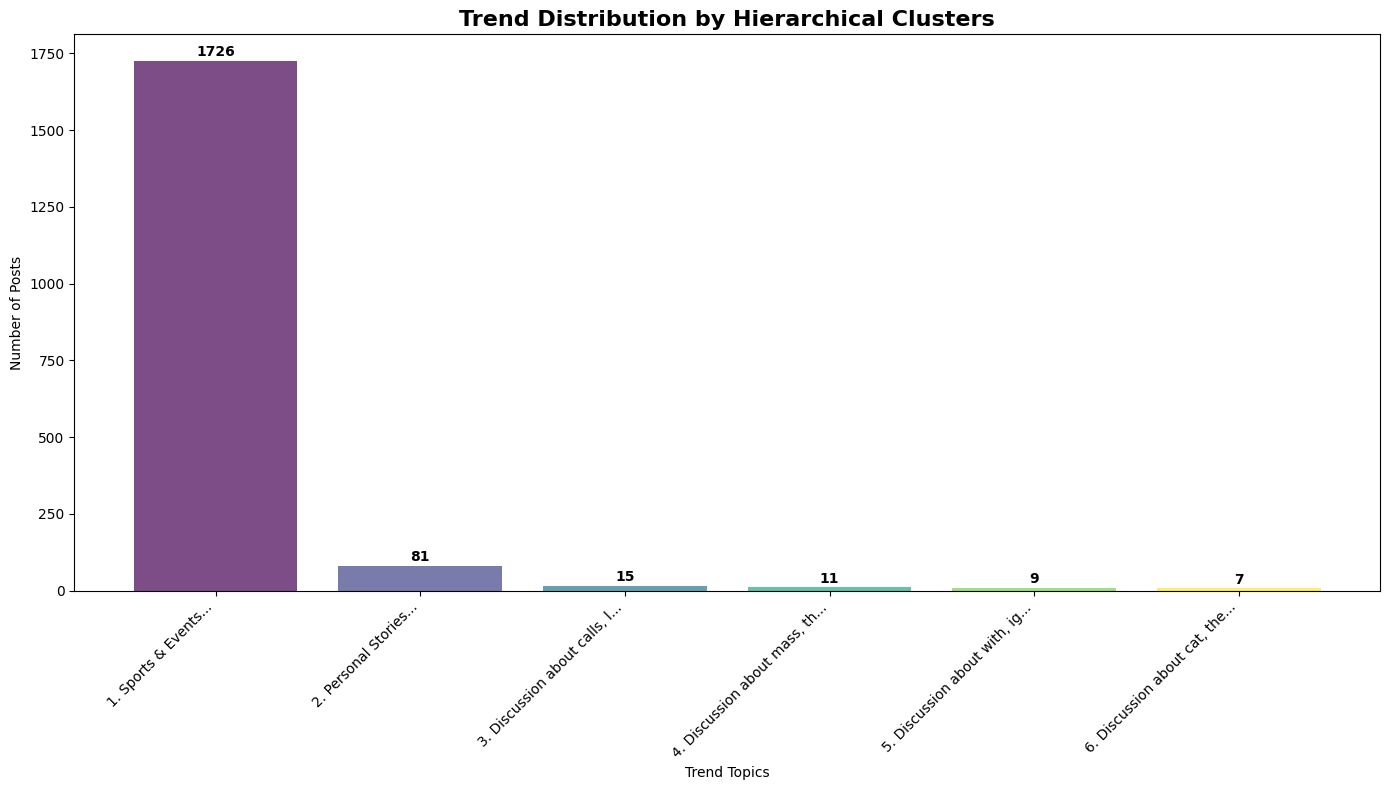

In [36]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

print("TREND DETECTION WITH HIERARCHICAL CLUSTERS (WITH TOPIC LABELING)")
print("=" * 70)

df_trend = df_small_nonzero.copy()  # clustered hierarchical sample

# --- Functions for trend detection and labeling ---

def filter_meaningful_keywords(keywords, texts):
    generic_words = {
        'like', 'just', 'know', 'think', 'people', 'really', 'would', 'could', 
        'should', 'dont', 'cant', 'wont', 'get', 'got', 'see', 'look', 'said',
        'say', 'make', 'made', 'time', 'good', 'great', 'bad', 'better', 'best',
        'right', 'wrong', 'way', 'thing', 'things', 'stuff', 'something', 'anything',
        'maybe', 'probably', 'actually', 'literally', 'basically', 'seriously'
    }
    meaningful = []
    for keyword in keywords:
        if (keyword not in generic_words and len(keyword) > 2 and not keyword.isdigit()):
            count = sum(1 for text in texts if keyword in text.lower())
            if count > len(texts) * 0.1:
                meaningful.append(keyword)
    return meaningful[:15]

def calculate_engagement(texts):
    if not texts:
        return 0
    avg_length = np.mean([len(text.split()) for text in texts])
    question_count = sum(1 for text in texts if '?' in text)
    exclamation_count = sum(1 for text in texts if '!' in text)
    score = min(10, (avg_length / 15) + (question_count / len(texts) * 3) + (exclamation_count / len(texts) * 2))
    return round(score, 1)

def identify_trend_topic(keywords, texts):
    all_text = ' '.join(texts).lower()
    keyword_str = ' '.join(keywords).lower()
    
    categories = {
        'Politics & Government': ['trump','biden','president','election','government','vote','law','policy','senate','congress'],
        'Entertainment & Movies': ['movie','film','marvel','disney','netflix','actor','director','trailer','scene','cinema','hollywood','oscar'],
        'Gaming & Esports': ['game','gaming','player','playstation','xbox','nintendo','steam','fortnite','minecraft','cod','level','multiplayer','console'],
        'Technology & Apps': ['iphone','android','apple','google','facebook','twitter','instagram','app','update','software','tech','device','computer','phone'],
        'Sports & Events': ['game','team','player','season','win','score','nfl','nba','mlb','soccer','football','basketball','baseball','championship','tournament'],
        'Social Issues': ['climate','environment','health','education','justice','rights','equality','protest','movement','change','society','community','future'],
        'Personal Stories': ['experience','story','life','family','friend','relationship','work','job','school','home','parent','child','love'],
        'Pop Culture': ['celebrity','famous','star','music','artist','album','song','youtube','tiktok','influencer','viral','trending','meme']
    }
    
    scores = {}
    for category, markers in categories.items():
        score = sum(1 for marker in markers if marker in keyword_str or marker in all_text)
        scores[category] = score
        
    best_category = max(scores, key=scores.get)
    if scores[best_category] < 2:  # fallback
        return f"Discussion about {', '.join(keywords[:2])}"
    return best_category

# --- Extract trends ---
trends = []
for cluster_id in sorted(df_trend['cluster'].unique()):
    cluster_texts = df_trend[df_trend['cluster']==cluster_id][text_column].tolist()
    if len(cluster_texts) < 5:  # skip very small clusters
        continue
    
    # Tokenize and count words
    all_words = ' '.join(cluster_texts).lower()
    words = re.findall(r'\b\w+\b', all_words)
    word_counts = Counter(words)
    
    # Top keywords
    top_keywords = [word for word, _ in word_counts.most_common(15)]
    meaningful_keywords = filter_meaningful_keywords(top_keywords, cluster_texts)
    
    if not meaningful_keywords:
        continue
    
    trends.append({
        'trend_id': cluster_id,
        'topic': identify_trend_topic(meaningful_keywords, cluster_texts),
        'size': len(cluster_texts),
        'percentage': len(cluster_texts) / len(df_trend) * 100,
        'keywords': meaningful_keywords[:8],
        'sample_posts': cluster_texts[:3],
        'engagement_score': calculate_engagement(cluster_texts)
    })

# Sort trends by size
trends = sorted(trends, key=lambda x: x['size'], reverse=True)

# --- Display trends ---
print(f"\nTRENDS FOUND ({len(trends)} total):")
for i, trend in enumerate(trends, 1):
    print(f"\n{i}. {trend['topic']}")
    print(f"   Volume: {trend['size']} posts ({trend['percentage']:.1f}%)")
    print(f"   Keywords: {', '.join(trend['keywords'][:5])}")
    print(f"   Engagement Score: {trend['engagement_score']}/10")
    print("   Sample posts:")
    for j, post in enumerate(trend['sample_posts'],1):
        preview = post[:120]+"..." if len(post)>120 else post
        print(f"      {j}. {preview}")

# --- Visualization ---
plt.figure(figsize=(14, 8))
trend_names = [f"{i+1}. {t['topic'][:25]}..." for i,t in enumerate(trends)]
trend_sizes = [t['size'] for t in trends]
colors = plt.cm.viridis(np.linspace(0,1,len(trends)))
bars = plt.bar(trend_names, trend_sizes, color=colors, alpha=0.7)

plt.title('Trend Distribution by Hierarchical Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Trend Topics')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
for bar, size in zip(bars, trend_sizes):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+5, f'{size}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


In [37]:
# --- Save hierarchical trend analysis to CSV ---
import pandas as pd

# Convert trends list of dicts to DataFrame
df_trends = pd.DataFrame(trends)

# Save to CSV
output_file = "hierarchical_trends_labeled.csv"
df_trends.to_csv(output_file, index=False)

print(f"\n✅ Hierarchical trends saved to '{output_file}'")



✅ Hierarchical trends saved to 'hierarchical_trends_labeled.csv'


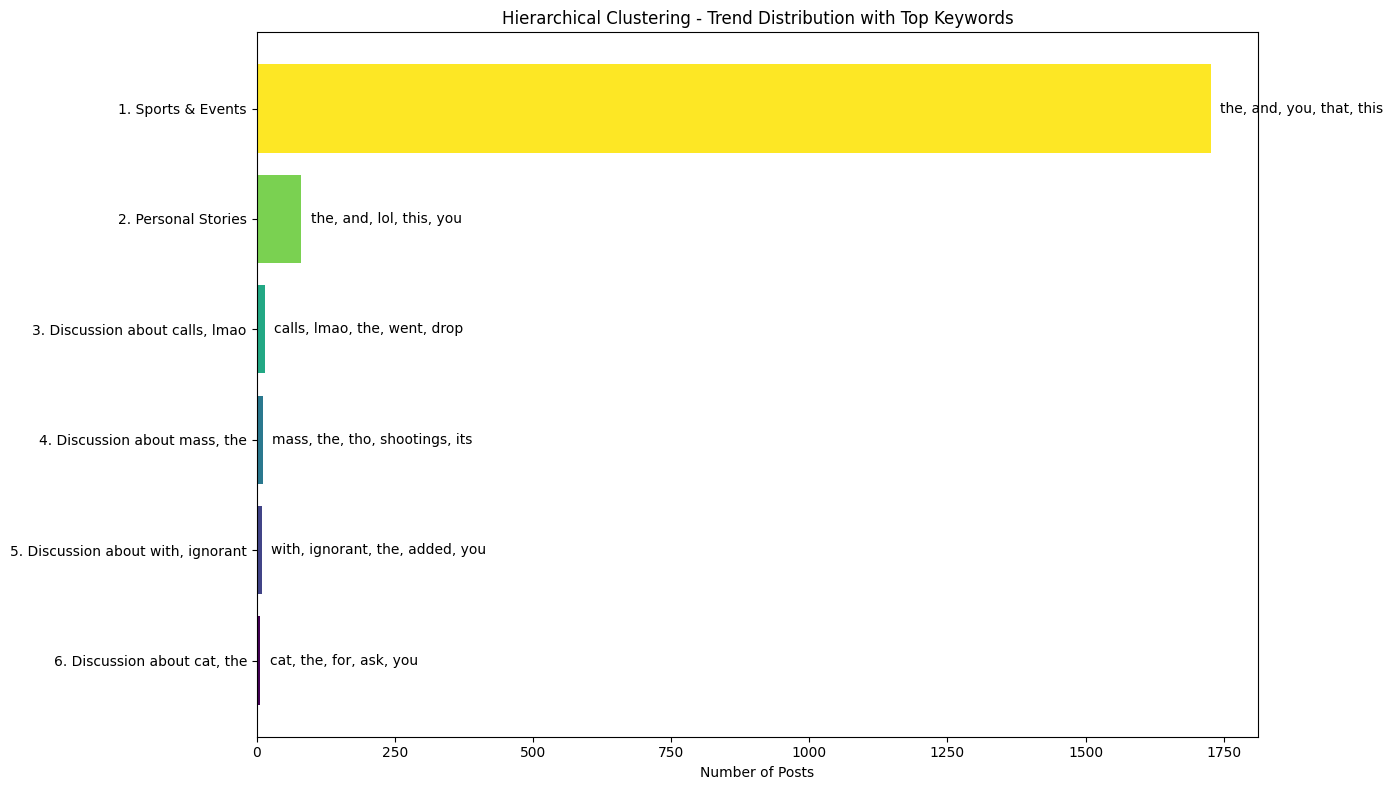

In [38]:
# --- Visualize Top Keywords and Trend Sizes ---
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
trend_labels = [f"{i+1}. {t['topic']}" for i, t in enumerate(trends)]
trend_sizes = [t['size'] for t in trends]
top_keywords = [', '.join(t['keywords'][:5]) for t in trends]  # top 5 keywords

# Bar chart for trend sizes
plt.figure(figsize=(14, 8))
bars = plt.barh(trend_labels[::-1], trend_sizes[::-1], color=plt.cm.viridis(np.linspace(0,1,len(trends))))
plt.xlabel("Number of Posts")
plt.title("Hierarchical Clustering - Trend Distribution with Top Keywords")

# Add top keywords as text next to bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(trend_sizes)*0.01, bar.get_y() + bar.get_height()/2,
             top_keywords[::-1][i], va='center', fontsize=10)

plt.tight_layout()
plt.show()


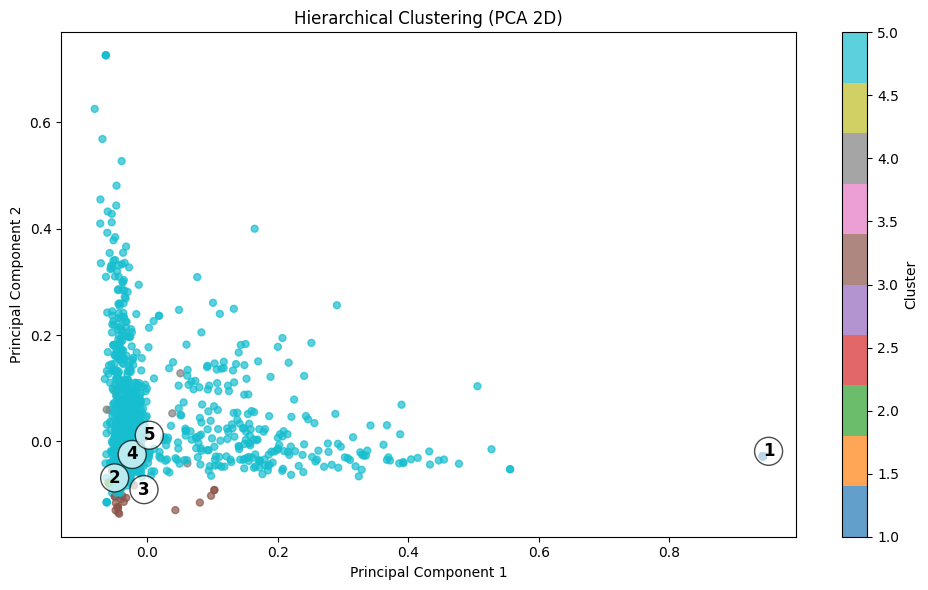

In [39]:
# --- 2D PCA Visualization for Hierarchical Clustering ---
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use TF-IDF matrix X (dense)
X_dense = X.toarray() if hasattr(X, "toarray") else X

# PCA to reduce TF-IDF to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_dense)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=df_small['cluster'], cmap='tab10',
    alpha=0.7, s=25
)

# Annotate cluster centers
for i in np.unique(df_small['cluster']):
    cluster_points = X_2d[df_small['cluster'] == i]
    if len(cluster_points) > 0:
        center = cluster_points.mean(axis=0)
        plt.text(center[0], center[1], str(i),
                 fontsize=12, weight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, boxstyle="circle,pad=0.3"))

plt.title("Hierarchical Clustering (PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


In [40]:
import os

# List all files in the hierarchical_results folder
folder_path = "hierarchical_results"
files = os.listdir(folder_path)
print(files)


['linkage_matrix.pkl', 'clustered_hierarchical.csv', 'tfidf_vectorizer.pkl']


In [41]:
import pandas as pd

df = pd.read_csv("hierarchical_results/clustered_hierarchical.csv")
print(df.head())


                                          clean_text  source  cluster
0  your dog looks very similar to my dog how old ...  reddit        2
1                   your chemistry puns are so basic  reddit        2
2  because the fact that we waste our time with t...  reddit        2
3               its not illegal to call someone that  reddit        2
4  we have a high iq person here folks tread ligh...  reddit        2


In [42]:
import pandas as pd
from collections import Counter

# Assuming your dataframe has columns: 'cluster' and maybe 'keywords'
print("Cluster distribution:")
cluster_counts = Counter(df['cluster'])
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} posts")

# Preview top keywords per cluster (if stored in a 'keywords' column)
if 'keywords' in df.columns:
    print("\nTop keywords per cluster:")
    for cluster_id in sorted(df['cluster'].unique()):
        sample_keywords = df[df['cluster'] == cluster_id]['keywords'].iloc[0]  # first row as example
        print(f"Cluster {cluster_id}: {sample_keywords}")
else:
    print("\nNo 'keywords' column found. You can extract them from your TF-IDF features if needed.")


Cluster distribution:
Cluster 1: 10 posts
Cluster 2: 1912 posts
Cluster 3: 7 posts
Cluster 4: 5 posts
Cluster 5: 26 posts

No 'keywords' column found. You can extract them from your TF-IDF features if needed.


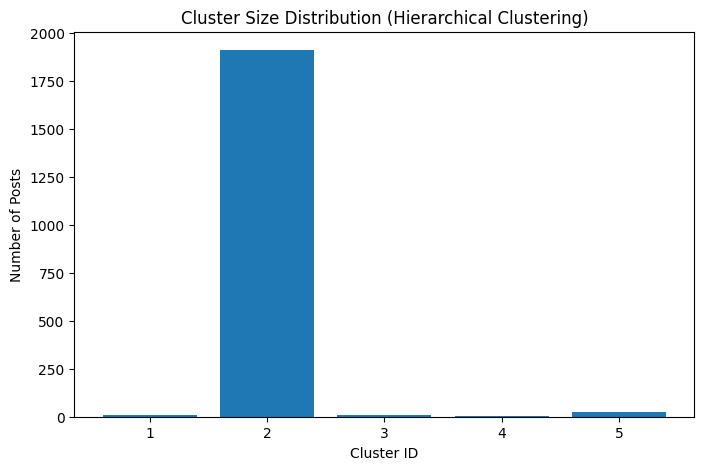

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Count clusters
cluster_counts = Counter(df['cluster'])

# Bar plot
plt.figure(figsize=(8,5))
plt.bar(cluster_counts.keys(), cluster_counts.values())
plt.xlabel("Cluster ID")
plt.ylabel("Number of Posts")
plt.title("Cluster Size Distribution (Hierarchical Clustering)")
plt.show()


In [44]:
import os

# Root directory to start searching
root_dir = "/kaggle"  # or "/" for full filesystem (might be slow)

csv_files = []
for dirpath, dirnames, filenames in os.walk(root_dir):
    for f in filenames:
        if f.endswith(".csv"):
            csv_files.append(os.path.join(dirpath, f))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(f)


Found 7 CSV files:
/kaggle/input/instagram/combined_captions_cleaned.csv
/kaggle/input/reddit/reddit.csv
/kaggle/working/clustered_data_hierarchical_sampled.csv
/kaggle/working/hierarchical_trends_labeled.csv
/kaggle/working/combined_cleaned_social_media.csv
/kaggle/working/hierarchical_clustered_sample.csv
/kaggle/working/hierarchical_results/clustered_hierarchical.csv


In [45]:
import pandas as pd

file_path = "/kaggle/working/hierarchical_results/clustered_hierarchical.csv"
df = pd.read_csv(file_path)

# Show the first few rows and column names
print("Columns:", df.columns.tolist())
print(df.head())


Columns: ['clean_text', 'source', 'cluster']
                                          clean_text  source  cluster
0  your dog looks very similar to my dog how old ...  reddit        2
1                   your chemistry puns are so basic  reddit        2
2  because the fact that we waste our time with t...  reddit        2
3               its not illegal to call someone that  reddit        2
4  we have a high iq person here folks tread ligh...  reddit        2


In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import numpy as np

# Load data
file_path = "/kaggle/working/hierarchical_results/clustered_hierarchical.csv"
df = pd.read_csv(file_path)

text_column = 'clean_text'
cluster_column = 'cluster'

# Split into train, validation, test (70/15/15)
train_val, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df[cluster_column])
train, val = train_test_split(train_val, test_size=0.1765, random_state=42, stratify=train_val[cluster_column])
# 0.1765 * 0.85 ≈ 0.15, so final split is 70/15/15

print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

# Function to compute cluster balance
def cluster_balance(data, cluster_col):
    counts = data[cluster_col].value_counts().sort_index()
    print("Cluster sizes:")
    print(counts)
    print("Cluster balance (std dev):", np.std(counts.values))
    print()

# Check cluster balance
print("Train set cluster balance:")
cluster_balance(train, cluster_column)
print("Validation set cluster balance:")
cluster_balance(val, cluster_column)
print("Test set cluster balance:")
cluster_balance(test, cluster_column)

# Optional: top keywords per cluster (using TF-IDF)
top_n_keywords = 5
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

for cluster_id in sorted(df[cluster_column].unique()):
    cluster_texts = df[df[cluster_column] == cluster_id][text_column].astype(str).tolist()
    X = vectorizer.fit_transform(cluster_texts)
    feature_names = vectorizer.get_feature_names_out()
    word_scores = np.array(X.sum(axis=0)).flatten()
    top_indices = word_scores.argsort()[::-1][:top_n_keywords]
    top_features = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster_id} top keywords: {', '.join(top_features)}")


Train: 1371, Validation: 295, Test: 294
Train set cluster balance:
Cluster sizes:
cluster
1       8
2    1337
3       5
4       3
5      18
Name: count, dtype: int64
Cluster balance (std dev): 531.4250276379538

Validation set cluster balance:
Cluster sizes:
cluster
1      1
2    288
3      1
4      1
5      4
Name: count, dtype: int64
Cluster balance (std dev): 114.50589504475305

Test set cluster balance:
Cluster sizes:
cluster
1      1
2    287
3      1
4      1
5      4
Name: count, dtype: int64
Cluster balance (std dev): 114.10591570992275

Cluster 1 top keywords: love, 3000, id, rivalry, execute
Cluster 2 top keywords: like, just, dont, im, people
Cluster 3 top keywords: dank, comment, meme, downvote, upvote
Cluster 4 top keywords: need, make, time, spam, just
Cluster 5 top keywords: spoilers, spoiler, automatically, moderators, bot


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import numpy as np

# Load your hierarchical clustering results
file_path = "/kaggle/working/hierarchical_results/clustered_hierarchical.csv"
df = pd.read_csv(file_path)

text_column = 'clean_text'
cluster_column = 'cluster'

# Split into train/validation/test (70/15/15)
train_val, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df[cluster_column])
train, val = train_test_split(train_val, test_size=0.1765, random_state=42, stratify=train_val[cluster_column])
# 0.1765 * 0.85 ≈ 0.15, so final split is 70/15/15

print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}\n")

# Function to compute cluster balance
def cluster_balance(data, cluster_col):
    counts = data[cluster_col].value_counts().sort_index()
    print("Cluster sizes:")
    print(counts)
    print("Cluster balance (std dev):", np.std(counts.values))
    print()

# Compute silhouette score
def compute_silhouette(data, text_col, cluster_col):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(data[text_col].astype(str))
    labels = data[cluster_col].values
    if len(np.unique(labels)) > 1:
        score = silhouette_score(X, labels)
    else:
        score = np.nan  # can't compute silhouette for 1 cluster
    return score

# Evaluate splits
splits = {'Train': train, 'Validation': val, 'Test': test}
for name, data in splits.items():
    print(f"--- {name} set ---")
    cluster_balance(data, cluster_column)
    score = compute_silhouette(data, text_column, cluster_column)
    print(f"Silhouette score: {score:.4f}\n")

# Optional: top keywords per cluster (sanity check)
top_n_keywords = 5
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

for cluster_id in sorted(df[cluster_column].unique()):
    cluster_texts = df[df[cluster_column] == cluster_id][text_column].astype(str).tolist()
    X = vectorizer.fit_transform(cluster_texts)
    feature_names = vectorizer.get_feature_names_out()
    word_scores = np.array(X.sum(axis=0)).flatten()
    top_indices = word_scores.argsort()[::-1][:top_n_keywords]
    top_features = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster_id} top keywords: {', '.join(top_features)}")


Train: 1371, Validation: 295, Test: 294

--- Train set ---
Cluster sizes:
cluster
1       8
2    1337
3       5
4       3
5      18
Name: count, dtype: int64
Cluster balance (std dev): 531.4250276379538

Silhouette score: 0.0170

--- Validation set ---
Cluster sizes:
cluster
1      1
2    288
3      1
4      1
5      4
Name: count, dtype: int64
Cluster balance (std dev): 114.50589504475305

Silhouette score: 0.0065

--- Test set ---
Cluster sizes:
cluster
1      1
2    287
3      1
4      1
5      4
Name: count, dtype: int64
Cluster balance (std dev): 114.10591570992275

Silhouette score: -0.0044

Cluster 1 top keywords: love, 3000, id, rivalry, execute
Cluster 2 top keywords: like, just, dont, im, people
Cluster 3 top keywords: dank, comment, meme, downvote, upvote
Cluster 4 top keywords: need, make, time, spam, just
Cluster 5 top keywords: spoilers, spoiler, automatically, moderators, bot
